In [4]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, RandomFlip, RandomRotation
from keras.layers import Resizing, Rescaling, Dropout, MaxPool2D, Activation, BatchNormalization, LeakyReLU
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import keras as k
import numpy as np
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import time

%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalizing the images
x_train, x_test = x_train / 255.0, x_test / 255.0

# Class names for the images
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170508288/170498071 [==============================] - 4s 0us/step


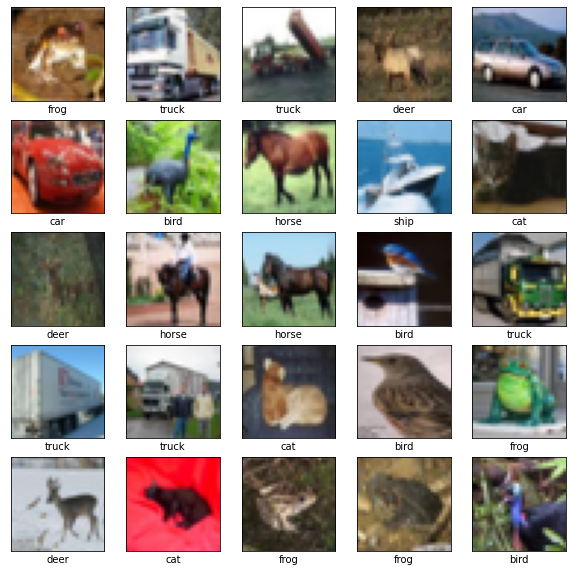

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [5]:
img_rows, img_cols, channels= 32,32,3

x_train_new = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test_new = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train_new.shape)
print(x_train_new.shape[0], 'train samples')
print(x_test_new.shape[0], 'test samples')

x_train_new = x_train_new.astype("float32")  
x_test_new = x_test_new.astype("float32")

y_train_new = tf.keras.utils.to_categorical(y_train, len(class_names))
y_test_new = tf.keras.utils.to_categorical(y_test, len(class_names))

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

datagen = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.15,
      height_shift_range=0.15,
      horizontal_flip=True,
      validation_split=0.2
      )

weight_decay = 1e-4
leaky_relu = LeakyReLU()
batch_size = 64

In [7]:
def cnn_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', input_shape=x_train_new.shape[1:]))
  model.add(Activation(leaky_relu))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same'))
  model.add(Activation(leaky_relu))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(64, (3,3), padding='same'))
  model.add(Activation(leaky_relu))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(Activation(leaky_relu))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))
  
  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(Activation(leaky_relu))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same'))
  model.add(Activation(leaky_relu))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Dense(512, activation='softmax'))
  model.add(Flatten())
  model.add(Dense(len(class_names), activation='softmax'))
  
  #data augmentation
  datagen.fit(x_train_new)
  
  opt_rms = optimizers.RMSprop(learning_rate=0.001, decay=1e-6)
  model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
  history = model.fit(datagen.flow(x_train_new, y_train_new, batch_size=batch_size),
                      steps_per_epoch=x_train_new.shape[0] // batch_size, epochs=150, shuffle=True,
                      verbose=1, validation_data=(x_train_new, y_train_new), 
                      callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule)])
  
  return model, history

In [8]:
start = time.time()
model, history = cnn_model()
end = time.time()

Epoch 1/150
781/781 [==============================] - 50s 50ms/step - loss: 1.6819 - accuracy: 0.3820 - val_loss: 1.4489 - val_accuracy: 0.4526 - lr: 0.0010
Epoch 2/150
781/781 [==============================] - 38s 48ms/step - loss: 1.3378 - accuracy: 0.5210 - val_loss: 1.2432 - val_accuracy: 0.5598 - lr: 0.0010
Epoch 3/150
781/781 [==============================] - 38s 48ms/step - loss: 1.1816 - accuracy: 0.5805 - val_loss: 1.3847 - val_accuracy: 0.5452 - lr: 0.0010
Epoch 4/150
781/781 [==============================] - 34s 43ms/step - loss: 1.0823 - accuracy: 0.6175 - val_loss: 1.9057 - val_accuracy: 0.4778 - lr: 0.0010
Epoch 5/150
781/781 [==============================] - 38s 48ms/step - loss: 1.0110 - accuracy: 0.6460 - val_loss: 1.1456 - val_accuracy: 0.6292 - lr: 0.0010
Epoch 6/150
781/781 [==============================] - 37s 48ms/step - loss: 0.9524 - accuracy: 0.6662 - val_loss: 1.1014 - val_accuracy: 0.6388 - lr: 0.0010
Epoch 7/150
781/781 [==============================]

In [56]:
print(f'Time taken for training: {(end - start):.2f}s')
print()
print('Scores on test')
scores = model.evaluate(x_test_new, y_test_new, verbose=1)
print(f'Accuracy on test data: {(scores[1] * 100):.2f}%')
print(f'Model Loss on test data: {scores[0]:.4f}')

Time taken for training: 5779.12s

Scores on test
313/313 [==============================] - 2s 5ms/step - loss: 0.3659 - accuracy: 0.8925
Accuracy on test data: 89.25%
Model Loss on test data: 0.3659


In [11]:
y_pred = np.argmax(model.predict(x_test_new), axis=1)
y_label = np.argmax(y_test_new, axis=1)
print(y_pred)
print(y_label)

[3 8 1 ... 5 1 7]
[3 8 8 ... 5 1 7]


In [13]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    confusion_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Heatmap of the classified test image labels:


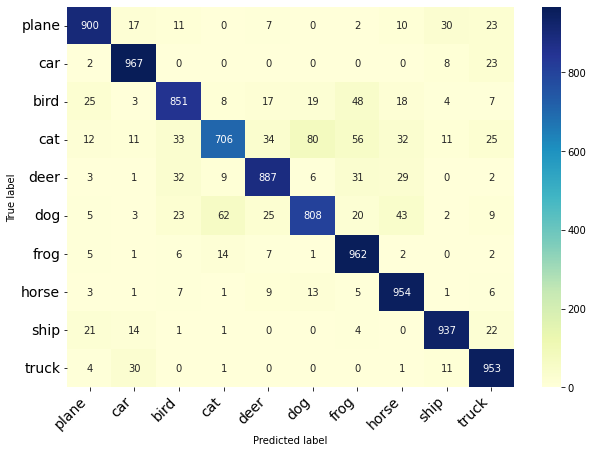

In [46]:
print('Heatmap of the classified test image labels:')
print_confusion_matrix(confusion_matrix(y_label, y_pred), class_names)

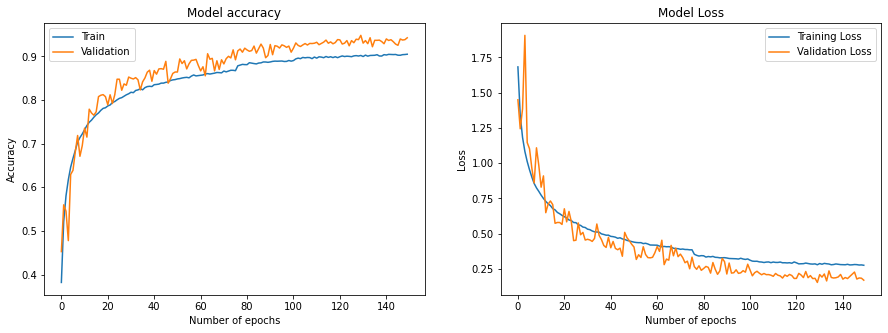

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title("Model Loss")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()